In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# 정상 트래픽
# 하위 폴더인 MachineLearningCVE 폴더에서 CSV 파일 읽기
df_normal = pd.read_csv("MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv")

# DDoS 공격 트래픽
df_ddos = pd.read_csv("MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

print("정상:", df_normal.shape)
print("공격:", df_ddos.shape)

정상: (529918, 79)
공격: (225745, 79)


In [4]:
# 정상 + 공격 데이터 하나로 합치기
df = pd.concat([df_normal, df_ddos], ignore_index=True)
print("전체 데이터 크기:", df.shape)

전체 데이터 크기: (755663, 79)


In [5]:
# 4단계: 제거할 컬럼이 없으므로 이 단계는 생략하거나 패스
print("삭제할 컬럼 없음. 패스!")

# 혹시나 컬럼이 있다면 지우고, 없으면 무시
df.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'], errors='ignore', inplace=True)

삭제할 컬럼 없음. 패스!


In [6]:
# 라벨 변환 (BENIGN → 0, 나머지 → 1)
# 1. 컬럼 이름 앞뒤 공백 제거 + 소문자로 바꾸기
df.columns = df.columns.str.strip().str.lower()

# 2. 'label' 컬럼: BENIGN → 0, 나머지 공격 → 1
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# 3. 라벨 분포 확인
print("라벨 분포:\n", df['label'].value_counts())

라벨 분포:
 label
0    627636
1    128027
Name: count, dtype: int64


In [7]:
# 결측값 및 이상치 처리
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [8]:
# 문자열 컬럼 숫자로 변환 (LabelEncoder)
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Label':
        df[col] = LabelEncoder().fit_transform(df[col])

In [9]:
#데이터 분할 (train/test)
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
# 랜덤 포레스트 모델 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

정확도: 0.9999602751607201

분류 리포트:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    125434
           1       1.00      1.00      1.00     25605

    accuracy                           1.00    151039
   macro avg       1.00      1.00      1.00    151039
weighted avg       1.00      1.00      1.00    151039



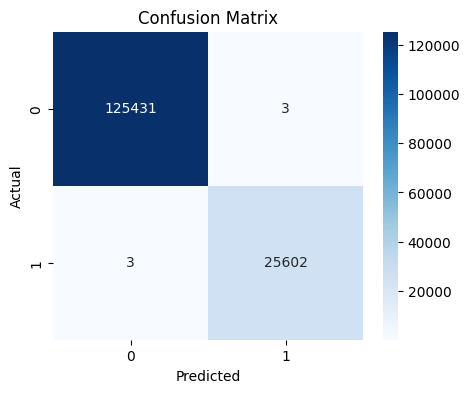

In [11]:
#모델 예측 및 평가
y_pred = clf.predict(X_test)

print("정확도:", accuracy_score(y_test, y_pred))
print("\n분류 리포트:")
print(classification_report(y_test, y_pred))

# 혼동 행렬 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()